In [1]:
#Incluya las principales librerias a utilizar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

# Data Final

| **Columna**     | **Significado**                                                                                                                                      |
| --------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| `open`          | Precio de apertura del día: primer precio al que se negoció CFG en la jornada.                                                                       |
| `high`          | Precio máximo del día: valor más alto alcanzado durante la sesión de trading.                                                                        |
| `low`           | Precio mínimo del día: valor más bajo alcanzado durante la sesión de trading.                                                                        |
| `close`         | Precio de cierre del día: último precio registrado al finalizar la jornada (marca el valor de referencia para el siguiente día).                     |
| `timestamp`     | Fecha y hora en que se registró el precio de cierre (en formato UTC).                                                                                |
| `volume_log`    | Volumen de transacciones diario transformado con `log1p` (log(1 + volumen)) para reducir sesgos y escala del dato original.                          |
| `marketCap_log` | Capitalización de mercado diaria transformada con `log1p` (log(1 + marketCap)) para homogeneizar la escala y atenuar el impacto de valores extremos. |


In [2]:

data = pd.read_csv('Data/new_data.csv')

In [3]:
data.head(-1)

,open,high,low,close,timestamp,volume_log,marketCap_log
0,0.899177,1.006647,0.875644,1.001213,2021-08-04 23:59:59.999000+00:00,13.731731,18.222792
1,1.000503,1.015743,0.952886,1.008229,2021-08-05 23:59:59.999000+00:00,13.294425,18.230246
2,1.009167,1.039124,0.961144,0.970035,2021-08-06 23:59:59.999000+00:00,13.584980,18.216175
3,0.969844,1.009587,0.925204,0.956226,2021-08-07 23:59:59.999000+00:00,13.562624,18.202207
4,0.956017,0.962150,0.895870,0.928109,2021-08-08 23:59:59.999000+00:00,13.338634,18.172780
...,...,...,...,...,...,...,...
1415,0.171802,0.183608,0.167320,0.167362,2025-06-19 23:59:59.999000+00:00,13.545267,18.355522
1416,0.167361,0.171724,0.161500,0.162862,2025-06-20 23:59:59.999000+00:00,12.880691,18.328345
1417,0.162862,0.165504,0.155131,0.157248,2025-06-21 23:59:59.999000+00:00,12.752461,18.293347
1418,0.157248,0.159123,0.139094,0.146956,2025-06-22 23:59:59.999000+00:00,13.300106,18.225762


# Posibles Features

| **Nueva Columna**      | **Derivación**                  | **Por qué es útil**                                                                             |
| ---------------------- | ------------------------------- | ----------------------------------------------------------------------------------------------- |
| `daily_return`         | `(close - open) / open`         | Captura el **rendimiento diario** de la moneda, clave para predecir tendencias de precio.       |
| `log_return`           | `np.log(close) - np.log(open)`  | Retorno logarítmico con mejor **aproximación normal**, útil en muchos modelos financieros.      |
| `price_range_pct`      | `(high - low) / open`           | Mide la **volatilidad intradía** en un solo valor normalizado.                                  |
| `std_return_7d`        | `daily_return.rolling(7).std()` | Desviación estándar móvil de retornos (7 días), refleja la **volatilidad reciente**.            |
| `ma_close_7d`          | `close.rolling(7).mean()`       | Media móvil a 7 días del precio de cierre, suaviza ruido y muestra **tendencia a corto plazo**. |
| `ma_close_30d`         | `close.rolling(30).mean()`      | Media móvil a 30 días, detecta **tendencia a mediano/largo plazo**.                             |
| `momentum_7d`          | `close - close.shift(7)`        | Medida de **momentum**, cuánto ha cambiado el precio en la última semana.                       |
| `volume_log_change`    | `volume_log.diff()`             | Varia­ción diaria del volumen (log), ayuda a detectar **picos o caídas repentinas** de trading. |
| `volume_log_ma_7d`     | `volume_log.rolling(7).mean()`  | Suaviza el volumen para identificar **tendencias de interés** en el mercado.                    |
| `marketcap_log_change` | `marketCap_log.diff()`          | Cambio diario en capitalización (log), indicador de **flujo de inversión**.                     |
| `liq_ratio`            | `volume_log / marketCap_log`    | Relación entre volumen y capitalización, mide la **liquidez relativa** de la criptomoneda.      |


**¿Por qué crear estas features?**

* **Rendimiento y momentum** (`daily_return`, `log_return`, `momentum_7d`): ayudan a tu modelo a aprender la dirección y velocidad de los movimientos de precio.
* **Volatilidad** (`price_range_pct`, `std_return_7d`): es un factor clave en finanzas para cuantificar riesgo.
* **Tendencia** (`ma_close_7d`, `ma_close_30d`): media móvil te permite diferenciar ruido de patrones reales de subida o bajada.
* **Actividad de mercado** (`volume_log_change`, `volume_log_ma_7d`, `marketcap_log_change`, `liq_ratio`): todas estas capturan cambios y niveles de participación que a menudo anticipan giros de precio.

Con estas nuevas columnas tendre un **set de features mucho más rico** que cubre precio, volatilidad, momentum y volumen, lo que suele mejorar significativamente el desempeño de modelos de regresión, clasificación de tendencias, o incluso modelos de series temporales avanzados.


# Ingeniería de Características

In [4]:
#!pip install ta


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           1421 non-null   float64
 1   high           1421 non-null   float64
 2   low            1421 non-null   float64
 3   close          1421 non-null   float64
 4   timestamp      1421 non-null   object 
 5   volume_log     1421 non-null   float64
 6   marketCap_log  1421 non-null   float64
dtypes: float64(6), object(1)
memory usage: 77.8+ KB


In [6]:
data.tail()

,open,high,low,close,timestamp,volume_log,marketCap_log
1416,0.167361,0.171724,0.161500,0.162862,2025-06-20 23:59:59.999000+00:00,12.880691,18.328345
1417,0.162862,0.165504,0.155131,0.157248,2025-06-21 23:59:59.999000+00:00,12.752461,18.293347
1418,0.157248,0.159123,0.139094,0.146956,2025-06-22 23:59:59.999000+00:00,13.300106,18.225762
1419,0.146956,0.159485,0.145891,0.159236,2025-06-23 23:59:59.999000+00:00,13.922737,18.306124
1420,0.159236,0.221995,0.157215,0.201760,2025-06-24 23:59:59.999000+00:00,16.175236,18.542870


In [7]:
import pandas as pd
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD

# ===== RSI =====
rsi = RSIIndicator(close=data['close'], window=14)
data['rsi_14'] = rsi.rsi()

# ===== MACD =====
macd = MACD(close=data['close'], window_slow=26, window_fast=12, window_sign=9)
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()
data['macd_diff'] = macd.macd_diff()

# ===== Estocástico =====
stoch = StochasticOscillator(high=data['high'], low=data['low'], close=data['close'], window=14, smooth_window=3)
data['stoch_k'] = stoch.stoch()
data['stoch_d'] = stoch.stoch_signal()


In [8]:

# Mostrar columnas nuevas
data[['rsi_14', 'macd', 'macd_signal', 'macd_diff', 'stoch_k', 'stoch_d']].tail()

,rsi_14,macd,macd_signal,macd_diff,stoch_k,stoch_d
1416,41.236863,-0.004551,-0.001956,-0.002595,2.660144,7.425211
1417,39.123205,-0.005749,-0.002714,-0.003034,3.674533,3.833743
1418,35.528495,-0.007443,-0.003660,-0.003783,10.677706,5.670794
1419,42.336879,-0.007705,-0.004469,-0.003236,27.356484,13.902908
1420,58.629138,-0.004431,-0.004461,0.000030,75.591507,37.875232


In [9]:
data["timestamp"] = pd.to_datetime(data["timestamp"], utc=True)

In [10]:
data.set_index("timestamp", inplace=True)

In [11]:
def create_features_ST(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    return df

In [12]:
data = create_features_ST(data)

In [13]:
#data["daily_return"] = data["close"].pct_change()
#data["log_return"] = np.log(data["close"]) - np.log(data["open"])
    #data["log_return"] = data["log_return"].fillna(0)
data["price_range_pct"] = (data["high"] - data["low"]) /data["open"]
#data["std_return_7d"] = data["daily_return"].rolling(window=7).std()
#data["ma_close_7d"] = data["close"].rolling(window=7).mean()
#data["ma_close_30d"] = data["close"].rolling(window=30).mean()
    #data["ma_volume_7d"] = data["volume_log"].rolling(window=7).mean()
#data["momentum_7d"] = data["close"].diff(7)
data["volume_log_change"] = data["volume_log"].diff()
data["volume_log_ma_7d"] = data["volume_log"].rolling(window=7).mean()
data["marketCap_log_change"] = data["marketCap_log"].diff()
data["liq_ratio"] = data["volume_log"] / data["marketCap_log"]

In [14]:
data.head(33)

,open,high,low,close,volume_log,marketCap_log,rsi_14,macd,macd_signal,macd_diff,...,year,month,day,day_of_week,quarter,price_range_pct,volume_log_change,volume_log_ma_7d,marketCap_log_change,liq_ratio
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-08-04 23:59:59.999000+00:00,0.899177,1.006647,0.875644,1.001213,13.731731,18.222792,NaN,NaN,NaN,NaN,...,2021,8,4,2,3,0.145693,NaN,NaN,NaN,0.753547
2021-08-05 23:59:59.999000+00:00,1.000503,1.015743,0.952886,1.008229,13.294425,18.230246,NaN,NaN,NaN,NaN,...,2021,8,5,3,3,0.062825,-0.437306,NaN,0.007455,0.729251
2021-08-06 23:59:59.999000+00:00,1.009167,1.039124,0.961144,0.970035,13.584980,18.216175,NaN,NaN,NaN,NaN,...,2021,8,6,4,3,0.077272,0.290555,NaN,-0.014072,0.745765
2021-08-07 23:59:59.999000+00:00,0.969844,1.009587,0.925204,0.956226,13.562624,18.202207,NaN,NaN,NaN,NaN,...,2021,8,7,5,3,0.087007,-0.022356,NaN,-0.013968,0.745109
2021-08-08 23:59:59.999000+00:00,0.956017,0.962150,0.895870,0.928109,13.338634,18.172780,NaN,NaN,NaN,NaN,...,2021,8,8,6,3,0.069330,-0.223990,NaN,-0.029427,0.733990
2021-08-09 23:59:59.999000+00:00,0.927920,1.036425,0.892264,1.016407,14.105058,18.264044,NaN,NaN,NaN,NaN,...,2021,8,9,0,3,0.155359,0.766424,NaN,0.091264,0.772286
2021-08-10 23:59:59.999000+00:00,1.014250,1.045132,0.941990,0.980695,13.644657,18.228697,NaN,NaN,NaN,NaN,...,2021,8,10,1,3,0.101693,-0.460401,13.608873,-0.035347,0.748526
2021-08-11 23:59:59.999000+00:00,0.980661,1.014194,0.902230,0.934291,13.981166,18.180618,NaN,NaN,NaN,NaN,...,2021,8,11,2,3,0.114172,0.336509,13.644506,-0.048079,0.769015
2021-08-12 23:59:59.999000+00:00,0.934064,0.976274,0.912073,0.926195,13.538078,18.172325,NaN,NaN,NaN,NaN,...,2021,8,12,3,3,0.068733,-0.443088,13.679314,-0.008293,0.744983


In [15]:
data.dropna(inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1388 entries, 2021-09-06 23:59:59.999000+00:00 to 2025-06-24 23:59:59.999000+00:00
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  1388 non-null   float64
 1   high                  1388 non-null   float64
 2   low                   1388 non-null   float64
 3   close                 1388 non-null   float64
 4   volume_log            1388 non-null   float64
 5   marketCap_log         1388 non-null   float64
 6   rsi_14                1388 non-null   float64
 7   macd                  1388 non-null   float64
 8   macd_signal           1388 non-null   float64
 9   macd_diff             1388 non-null   float64
 10  stoch_k               1388 non-null   float64
 11  stoch_d               1388 non-null   float64
 12  year                  1388 non-null   int32  
 13  month                 1388 non-null   int32  
 14  day       

# Modelamiento

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Paso 1 - Regresión Directa del Precio

En este enfoque modelaremos el close al día t + Δt como una variable continua. Sobre la serie histórica de precios, volumen y capitalización, así como algunos indicadores técnicos. 

Hipotesis:

Se espera que los resultados de la regresión, muestren que la curva resultante de la validación se ajuste a los datos reales, y que el forcasting tengan un comportamiento razonable. De esta manera, el cliente podrá tomar decisiones informada.

In [18]:
import numpy as np

def create_sliding_windows(data, features, target="close", window_size=7):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[features].iloc[i - window_size:i].values)
        y.append(data[target].iloc[i])
    return np.array(X), np.array(y)

features = ['close', 'volume_log', 'marketCap_log', 'rsi_14',
       'macd', 'macd_signal', 'macd_diff', 'stoch_k', 'stoch_d', 'year',
       'month', 'day', 'day_of_week', 'quarter', 'price_range_pct',
       'volume_log_change', 'volume_log_ma_7d', 'marketCap_log_change',
       'liq_ratio']
X, y = create_sliding_windows(data, features, window_size=7)

In [19]:
X_flat = X.reshape(X.shape[0], -1)

In [20]:
column_names = []
for i in range(7, 0, -1):  # t-3, t-2, t-1
    for feature in features:
        column_names.append(f"{feature}_t-{i}")

df_sliding = pd.DataFrame(X_flat, columns=column_names)
df_sliding["target_close_t"] = y 

# Mostrar resultado
df_sliding.loc[:, ["close_t-7","close_t-6","close_t-5","close_t-4","close_t-3","close_t-2","close_t-1","target_close_t"]]  

,close_t-7,close_t-6,close_t-5,close_t-4,close_t-3,close_t-2,close_t-1,target_close_t
0,1.158519,1.121489,1.105229,1.132404,1.090242,1.105972,1.097787,1.082508
1,1.121489,1.105229,1.132404,1.090242,1.105972,1.097787,1.082508,1.120064
2,1.105229,1.132404,1.090242,1.105972,1.097787,1.082508,1.120064,1.129997
3,1.132404,1.090242,1.105972,1.097787,1.082508,1.120064,1.129997,1.071238
4,1.090242,1.105972,1.097787,1.082508,1.120064,1.129997,1.071238,1.020058
...,...,...,...,...,...,...,...,...
1376,0.167504,0.180435,0.195179,0.184645,0.170586,0.171802,0.167362,0.162862
1377,0.180435,0.195179,0.184645,0.170586,0.171802,0.167362,0.162862,0.157248
1378,0.195179,0.184645,0.170586,0.171802,0.167362,0.162862,0.157248,0.146956
1379,0.184645,0.170586,0.171802,0.167362,0.162862,0.157248,0.146956,0.159236


### LinearRegression

In [21]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, shuffle=False)

linearRegreModel = LinearRegression()
linearRegreModel.fit(X_train, y_train)


preds_LR = linearRegreModel.predict(X_test)
mse = mean_squared_error(y_test, preds_LR)
print(f"MSE: {mse:.4f}")

MSE: 0.0003


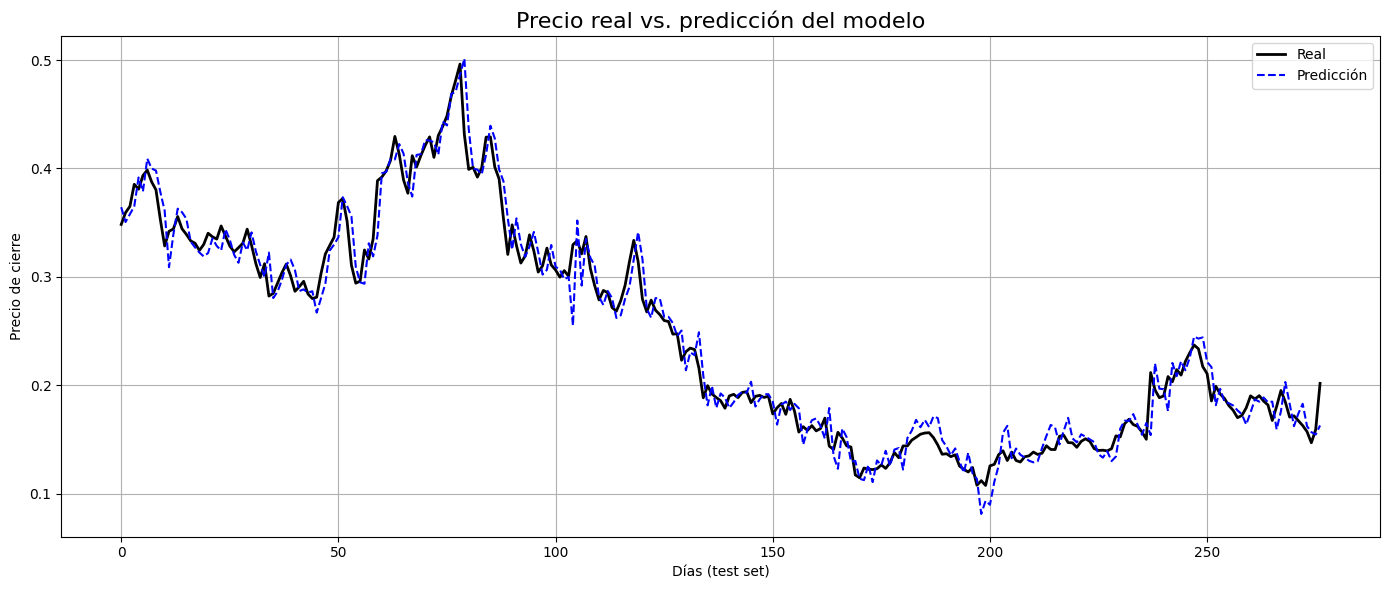

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Real', color='black', linewidth=2)
plt.plot(preds_LR, label='Predicción', color='blue', linestyle='--')
plt.title("Precio real vs. predicción del modelo", fontsize=16)
plt.xlabel("Días (test set)")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


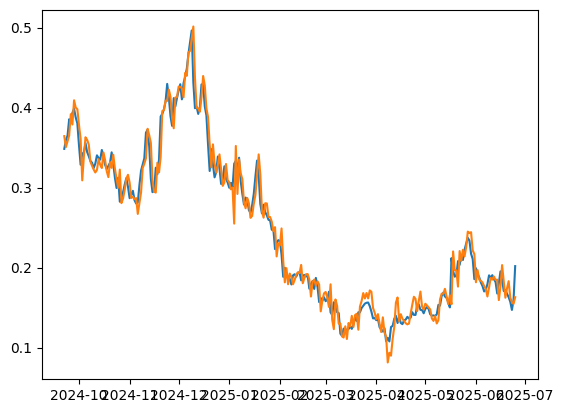

In [23]:
fechas_test = data.index[-len(y_test):]  # solo si tu DataFrame tiene índice tipo datetime
plt.plot(fechas_test, y_test, label='Real')
plt.plot(fechas_test, preds_LR, label='Predicción')

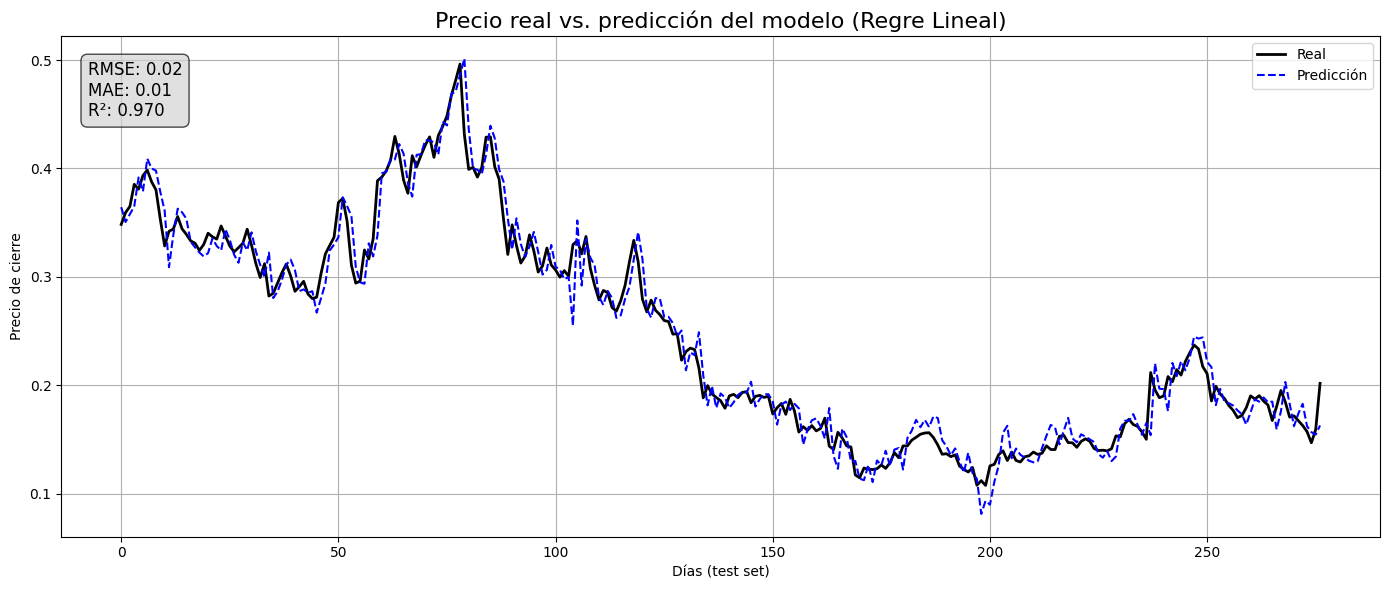

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, preds_LR))
mae = mean_absolute_error(y_test, preds_LR)
r2 = r2_score(y_test, preds_LR)

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Real', color='black', linewidth=2)
plt.plot(preds_LR, label='Predicción', color='blue', linestyle='--')

plt.title("Precio real vs. predicción del modelo (Regre Lineal)", fontsize=16)
plt.xlabel("Días (test set)")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(True)

# Mostrar métricas en el gráfico
textstr = '\n'.join((
    f'RMSE: {rmse:.2f}',
    f'MAE: {mae:.2f}',
    f'R²: {r2:.3f}'
))
plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', alpha=0.7))

plt.tight_layout()
plt.show()


### RandomForest

In [25]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, shuffle=False)

rfr_model = RandomForestRegressor(random_state=42,n_jobs=-1)
rfr_model.fit(X_train, y_train)

# Evaluación
preds = rfr_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(f"MSE: {mse:.4f}")

MSE: 0.0006


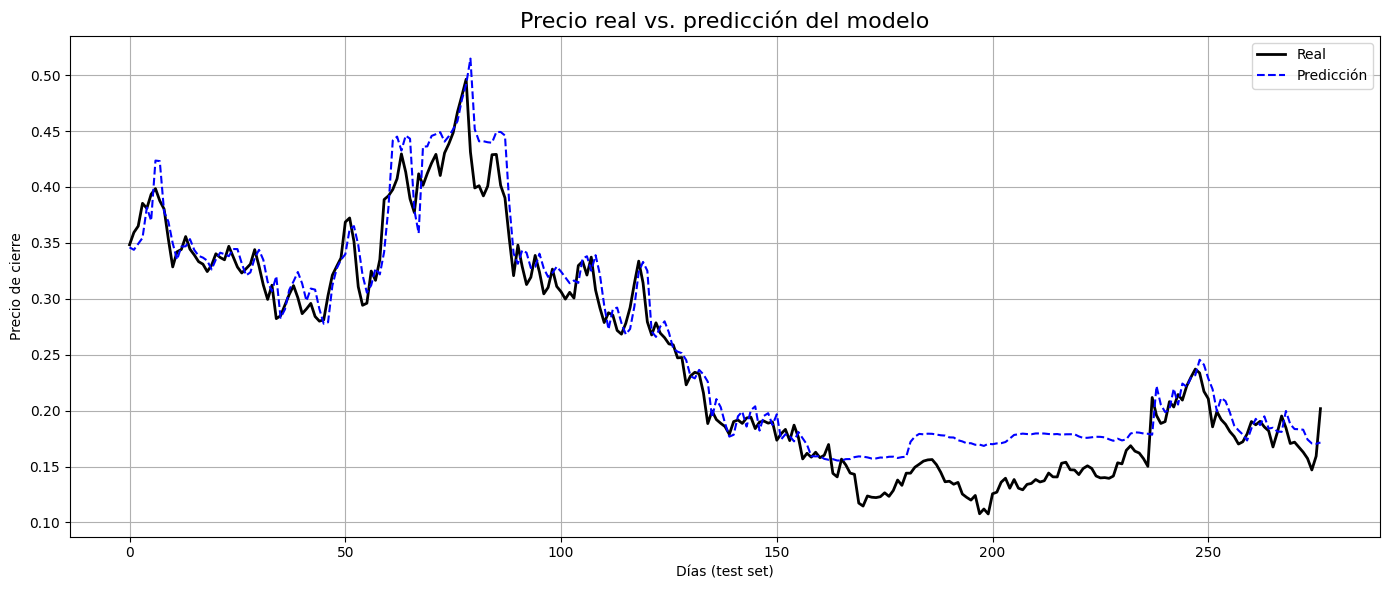

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Real', color='black', linewidth=2)
plt.plot(preds, label='Predicción', color='blue', linestyle='--')
plt.title("Precio real vs. predicción del modelo", fontsize=16)
plt.xlabel("Días (test set)")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

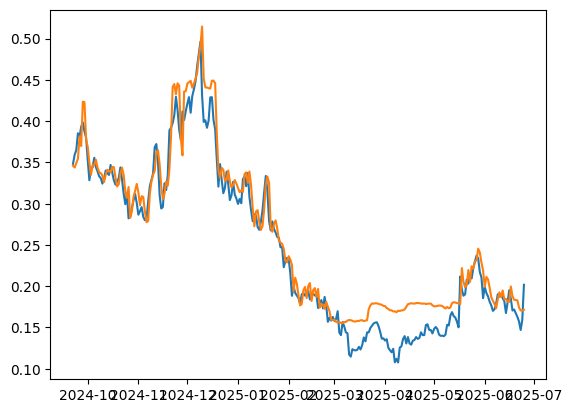

In [27]:
fechas_test = data.index[-len(y_test):]  # solo si tu DataFrame tiene índice tipo datetime
plt.plot(fechas_test, y_test, label='Real')
plt.plot(fechas_test, preds, label='Predicción')

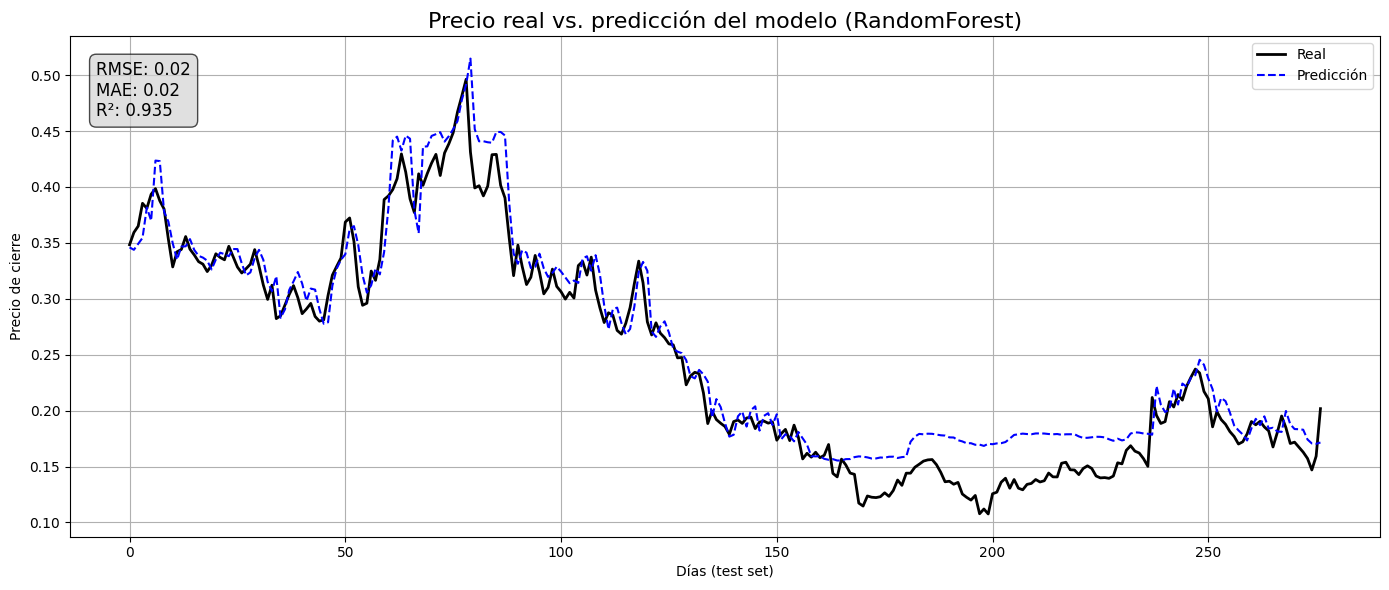

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Real', color='black', linewidth=2)
plt.plot(preds, label='Predicción', color='blue', linestyle='--')

plt.title("Precio real vs. predicción del modelo (RandomForest)", fontsize=16)
plt.xlabel("Días (test set)")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(True)

# Mostrar métricas en el gráfico
textstr = '\n'.join((
    f'RMSE: {rmse:.2f}',
    f'MAE: {mae:.2f}',
    f'R²: {r2:.3f}'
))
plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', alpha=0.7))

plt.tight_layout()
plt.show()

### Red Neuronal

In [29]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
#Para red neuronal
def create_sequences(data, prices, past_steps, future_steps):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps + 1):
        X.append(data[i:i + past_steps])
        y.append(prices[i + past_steps:i + past_steps + future_steps])
    return np.array(X), np.array(y)


(1103, 7, 19) (1103, 1, 1)


c:\Users\karim\anaconda3\envs\DataScience\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


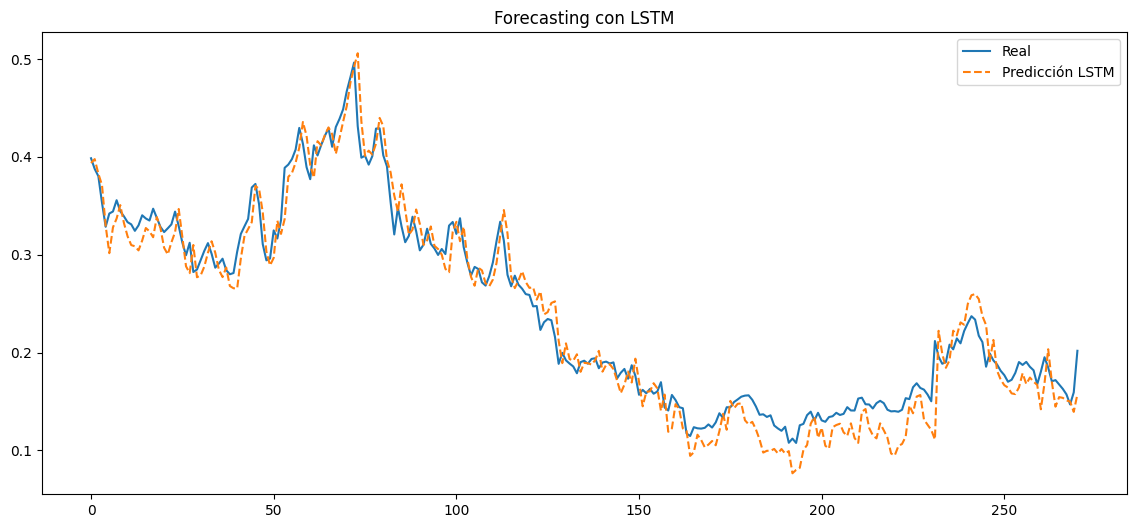

In [30]:
# Parámetros
X2,y2 = data[features].values, data['close'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)
past_steps = 7   # días de historial para mirar atrás
future_steps = 1  # días a predecir (puedes cambiarlo)

# Normalización (opcional pero recomendado para LSTM)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_train_scaled = scaler_x.fit_transform(X_train2)
y_train_scaled = scaler_y.fit_transform(y_train2.reshape(-1, 1))
x_test_scaled = scaler_x.transform(X_test2)
y_test_scaled = scaler_y.transform(y_test2.reshape(-1, 1))

# Crear secuencias para LSTM
# Pasa y_train_scaled y y_test_scaled como 2D arrays (no flatten)
X_seq, y_seq = create_sequences(x_train_scaled, y_train_scaled, past_steps, future_steps)
X_seq_test, y_seq_test = create_sequences(x_test_scaled, y_test_scaled, past_steps, future_steps)

# Ajustar dimensiones para Keras (samples, timesteps, features)
print(X_seq.shape, y_seq.shape)  # (n_samples, past_steps, n_features), (n_samples, future_steps)

# Ajustar y_seq y y_seq_test a 2D (samples, future_steps)
y_seq_2d = y_seq.reshape(y_seq.shape[0], y_seq.shape[1])
y_seq_test_2d = y_seq_test.reshape(y_seq_test.shape[0], y_seq_test.shape[1])

# Modelo LSTM simple
model = Sequential([
    LSTM(64, input_shape=(past_steps, x_train_scaled.shape[1]), return_sequences=False),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# Entrenamiento
history = model.fit(X_seq, y_seq_2d, epochs=30, batch_size=32, validation_data=(X_seq_test, y_seq_test_2d), verbose=False)

# Predicción
y_pred_scaled = model.predict(X_seq_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_seq_test.reshape(-1, y_seq_test.shape[-1])).reshape(y_seq_test.shape[0], y_seq_test.shape[1])

# Ejemplo de gráfico
plt.figure(figsize=(14, 6))
plt.plot(y_true.flatten(), label='Real')
plt.plot(y_pred.flatten(), label='Predicción LSTM', linestyle='--')
plt.legend()
plt.title("Forecasting con LSTM")
plt.show()

#### Rolling Predict

In [31]:
def rolling_predict(model, last_window, steps_ahead, window_size, num_features):
    """
    model: modelo entrenado (por ejemplo, LinearRegression)
    last_window: última ventana de datos usada como input (shape: [window_size, num_features])
    steps_ahead: número de días a predecir
    """
    preds = []
    window = last_window.copy()

    for _ in range(steps_ahead):
        # Aplanar la ventana para ajustarla al modelo
        X_input = window.reshape(1, -1)
        
        # Hacer predicción
        pred = model.predict(X_input)[0]
        preds.append(pred)

        # Simular la próxima ventana (deslizar + agregar predicción)
        new_row = window[-1].copy()
        new_row[0] = pred  # Sobrescribimos el 'close' futuro con la predicción
        window = np.vstack([window[1:], new_row])  # desplazamos la ventana

    return preds


In [32]:
# Tomamos la última ventana real disponible del dataset original
last_X_window = X[-1]  # tiene shape (window_size, num_features)


In [33]:
futuro = rolling_predict(model=rfr_model,
                         last_window=last_X_window,
                         steps_ahead=30,         # predice 30 días futuros
                         window_size=7,
                         num_features=X.shape[2])

futuro_regrelineal = rolling_predict(model=linearRegreModel,
                         last_window=last_X_window,
                         steps_ahead=30,         # predice 30 días futuros
                         window_size=7,
                         num_features=X.shape[2])


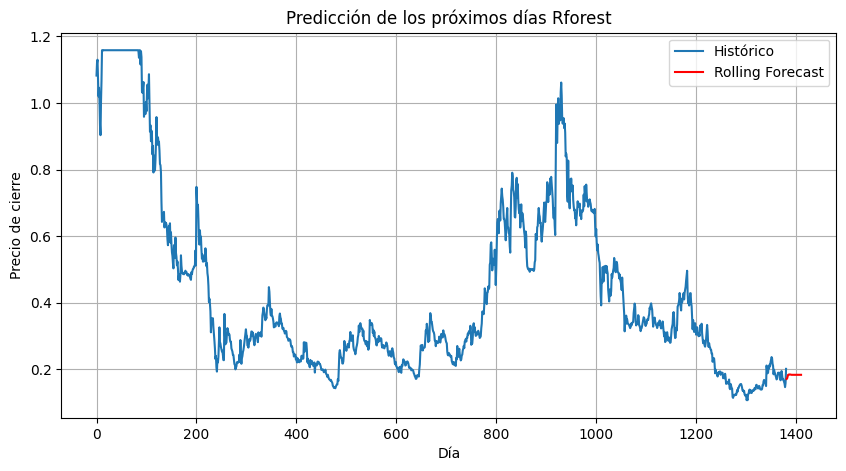

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(y)), y, label='Histórico')
plt.plot(range(len(y), len(y) + len(futuro)), futuro, label='Rolling Forecast', color='red')
plt.title("Predicción de los próximos días Rforest")
plt.xlabel("Día")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(True)
plt.show()


#### LSTM

In [35]:
def forecast_next_n_days_lstm(model, data, scaler_x, scaler_y, features, past_steps=7, n_days=30):
    """
    Realiza un forecast de los próximos n_days usando el modelo LSTM entrenado.
    """
    last_window = data[features].values[-past_steps:]
    window_scaled = scaler_x.transform(last_window)
    preds_scaled = []
    
    for _ in range(n_days):
        X_input = window_scaled.reshape(1, past_steps, -1)
        pred_scaled = model.predict(X_input, verbose=0)
        preds_scaled.append(pred_scaled[0, 0])
        next_row = window_scaled[-1].copy()
        close_idx = features.index('close')
        next_row[close_idx] = pred_scaled[0, 0]
        window_scaled = np.vstack([window_scaled[1:], next_row])
    
    preds_scaled = np.array(preds_scaled).reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds_scaled).flatten()
    return preds

In [36]:
preds_30dias_LSTM = forecast_next_n_days_lstm(model, data, scaler_x, scaler_y, features, past_steps=7, n_days=30)
print(preds_30dias_LSTM)

[0.22715165 0.27691564 0.32467687 0.36915806 0.40827772 0.44232473
 0.47344777 0.50240344 0.5309403  0.5576702  0.58261174 0.60588855
 0.62775534 0.6484617  0.6681379  0.6868734  0.7046543  0.7215526
 0.7376439  0.7529987  0.76767445 0.78171563 0.79516035 0.8080418
 0.82039726 0.83226013 0.84366006 0.8546237  0.86517555 0.8753379 ]


### Conclusiones

In [37]:
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=len(futuro), freq='D')

In [38]:
df_future = pd.DataFrame({
    "fecha": future_dates,
    "prediccion_close": futuro
}).set_index("fecha")

print(df_future)

                                  prediccion_close
fecha                                             
2025-06-25 23:59:59.999000+00:00          0.171472
2025-06-26 23:59:59.999000+00:00          0.172436
2025-06-27 23:59:59.999000+00:00          0.178167
2025-06-28 23:59:59.999000+00:00          0.183742
2025-06-29 23:59:59.999000+00:00          0.184014
2025-06-30 23:59:59.999000+00:00          0.185092
2025-07-01 23:59:59.999000+00:00          0.184739
2025-07-02 23:59:59.999000+00:00          0.184739
2025-07-03 23:59:59.999000+00:00          0.184739
2025-07-04 23:59:59.999000+00:00          0.184271
2025-07-05 23:59:59.999000+00:00          0.183902
2025-07-06 23:59:59.999000+00:00          0.183902
2025-07-07 23:59:59.999000+00:00          0.183902
2025-07-08 23:59:59.999000+00:00          0.183902
2025-07-09 23:59:59.999000+00:00          0.183902
2025-07-10 23:59:59.999000+00:00          0.183902
2025-07-11 23:59:59.999000+00:00          0.183902
2025-07-12 23:59:59.999000+00:0

In [39]:
serie1 = pd.Series(data.index[len(y)-13:], name="fechas_pasadas")
serie2 = pd.Series(df_future.index, name="fechas_futuras")
serie_unida = pd.concat([serie1, serie2], ignore_index=True).to_frame(name="fechas")


C:\Users\karim\AppData\Local\Temp\ipykernel_7456\3623484328.py:5: RuntimeWarning: invalid value encountered in log
  all_vals2 = np.concatenate([hist_vals, np.log(futuro_regrelineal)])


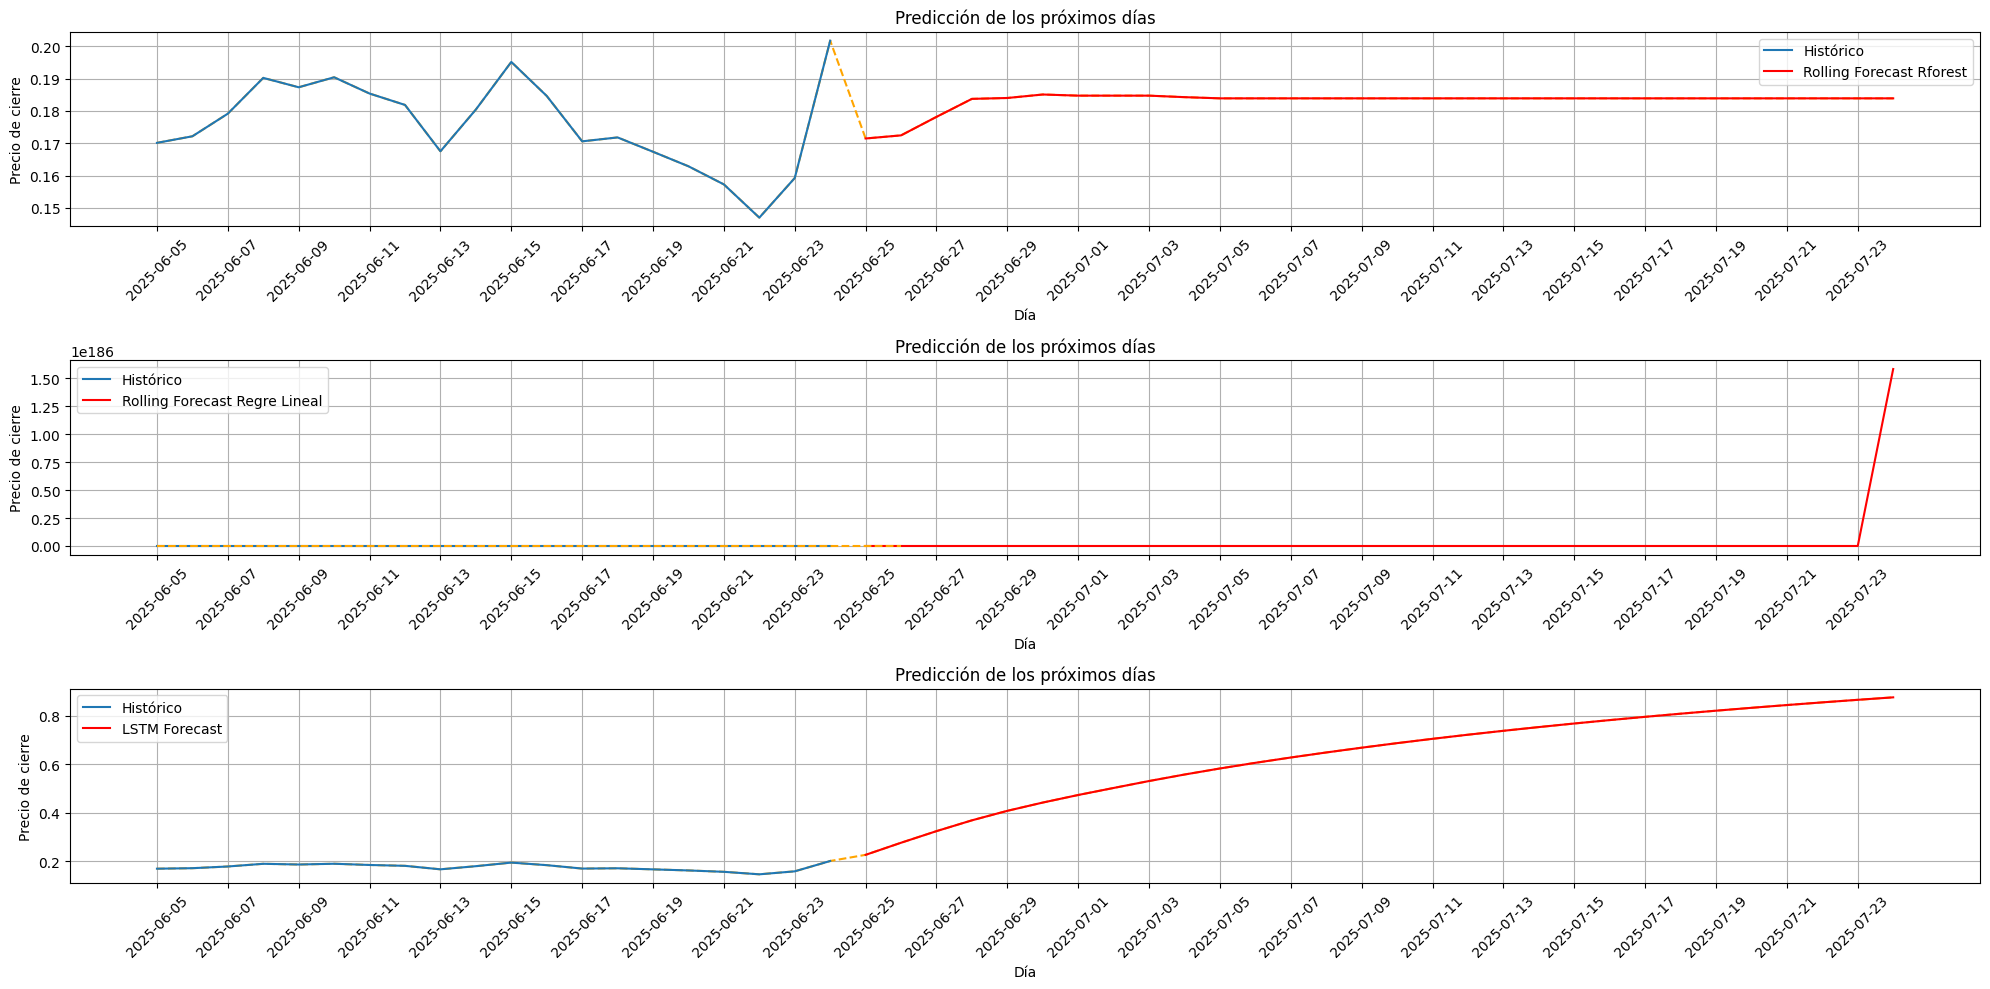

In [40]:
fig, ax = plt.subplots(figsize=(20, 10),nrows=3)

hist_vals = y[len(y)-20:]
all_vals = np.concatenate([hist_vals, futuro])
all_vals2 = np.concatenate([hist_vals, np.log(futuro_regrelineal)])
all_vals3 = np.concatenate([hist_vals, preds_30dias_LSTM])

#plt.figure(figsize=(10, 5))
ax[0].plot(serie_unida["fechas"], all_vals, color="orange", linestyle='--')
ax[0].plot(serie1, hist_vals, label='Histórico')
ax[0].plot(serie2, futuro, label='Rolling Forecast Rforest', color='red')
ax[0].legend()
ax[0].grid(True)
ax[0].set_title("Predicción de los próximos días")
ax[0].set_xlabel("Día")
ax[0].set_xticks(serie_unida["fechas"].loc[::2])
ax[0].set_xticklabels(serie_unida["fechas"].loc[::2].dt.strftime('%Y-%m-%d'), rotation=45)
ax[0].set_ylabel("Precio de cierre")


ax[1].plot(serie1, hist_vals, label='Histórico')

sns.lineplot(x=serie2, y=futuro_regrelineal, ax=ax[1],color="red", label='Rolling Forecast Regre Lineal')
ax[1].plot(serie_unida["fechas"], all_vals2, color="orange", linestyle='--')
ax[1].legend()
ax[1].grid(True)
ax[1].set_title("Predicción de los próximos días")
ax[1].set_xlabel("Día")
ax[1].set_xticks(serie_unida["fechas"].loc[::2])
ax[1].set_xticklabels(serie_unida["fechas"].loc[::2].dt.strftime('%Y-%m-%d'), rotation=45)
ax[1].set_ylabel("Precio de cierre")


ax[2].plot(serie_unida["fechas"], all_vals3, color="orange", linestyle='--')
ax[2].plot(serie1, hist_vals, label='Histórico')
ax[2].plot(serie2, preds_30dias_LSTM, label='LSTM Forecast', color='red')
ax[2].legend()
ax[2].grid(True)
ax[2].set_title("Predicción de los próximos días")
ax[2].set_xlabel("Día")
ax[2].set_xticks(serie_unida["fechas"].loc[::2])
ax[2].set_xticklabels(serie_unida["fechas"].loc[::2].dt.strftime('%Y-%m-%d'), rotation=45)
ax[2].set_ylabel("Precio de cierre")

fig.tight_layout()
plt.show()


En conclusión, predecir con precisión el precio exacto de un criptoactivo resulta inviable debido a la naturaleza altamente volátil y especulativa del mercado. Una de las principales limitaciones radica en la dificultad de capturar y modelar el sentimiento del mercado, el cual está impulsado por factores externos impredecibles y emocionales. Por ello, una alternativa más realista y útil sería enfocar el análisis en predecir la dirección del movimiento del precio (al alza o a la baja), en lugar de su valor numérico.



# Paso 2 - Clasificación Binaria (Sube/Baja)

### Hipotesis

Buscamos probar la siguiente hipotesis

"Podemos predecir la tendencia (subida o bajada) del precio del criptoactivo"

Bajo este detalle plenateanos el siguiente acercamiento: 


*   Binarizar los resultados de los precios predichos en el paso anterior
*   Implementar un modelo directo en la clasificacion de la tendencia



### Experimentacion

In [41]:
df_bin = df_sliding.copy()
df_bin['target'] = (df_bin['target_close_t'] - df_bin['close_t-1']) > 0
df_bin = df_bin.drop('target_close_t', axis=1)
df_bin.head()

,close_t-7,volume_log_t-7,marketCap_log_t-7,rsi_14_t-7,macd_t-7,macd_signal_t-7,macd_diff_t-7,stoch_k_t-7,stoch_d_t-7,year_t-7,...,month_t-1,day_t-1,day_of_week_t-1,quarter_t-1,price_range_pct_t-1,volume_log_change_t-1,volume_log_ma_7d_t-1,marketCap_log_change_t-1,liq_ratio_t-1,target
0,1.158519,14.106123,18.605889,65.642571,0.023875,0.028886,-0.005011,56.115566,56.115566,2021.0,...,9.0,12.0,6.0,3.0,0.024605,0.025575,13.799678,-0.007096,0.728568,False
1,1.121489,14.476924,18.491762,47.354066,0.019494,0.027008,-0.007514,20.357319,44.196150,2021.0,...,9.0,13.0,0.0,3.0,0.051160,0.293805,13.750226,-0.013599,0.745012,True
2,1.105229,13.842025,18.488447,41.841790,0.014542,0.024514,-0.009973,32.971196,36.481360,2021.0,...,9.0,14.0,1.0,3.0,0.081336,0.072113,13.658104,0.034436,0.747523,True
3,1.132404,13.530411,18.513069,51.916282,0.012664,0.022144,-0.009480,51.419531,34.916015,2021.0,...,9.0,15.0,2.0,3.0,0.035911,-0.327426,13.609908,0.009219,0.729464,False
4,1.090242,13.735525,18.475471,40.262908,0.007686,0.019253,-0.011567,22.797075,35.729267,2021.0,...,9.0,16.0,3.0,3.0,0.076612,0.101669,13.620752,-0.053084,0.737069,False


#### Binarizacion

In [42]:
y_regression = linearRegreModel.predict(df_bin.drop('target', axis=1))
y_regression_bin = (y_regression - df_sliding['close_t-1']) > 0

c:\Users\karim\anaconda3\envs\DataScience\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [43]:
y_randomforest = rfr_model.predict(df_bin.drop('target', axis=1))
y_randomforest_bin = (y_randomforest - df_sliding['close_t-1']) > 0

c:\Users\karim\anaconda3\envs\DataScience\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [44]:
b = model.predict(X_seq_test).flatten()
b = scaler_y.inverse_transform(b.reshape(-1, 1)).flatten()
temp = df_bin.tail(len(b))
y_lstm_bin = (b - temp['close_t-1']) > 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [45]:

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

def evaluate_classification_model(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)

  print("Confusion Matrix:")
  print(cm)
  print(f"\nAccuracy: {accuracy:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(f"Recall: {recall:.4f}")


In [46]:
evaluate_classification_model(df_bin['target'] ,y_regression_bin)

Confusion Matrix:
[[454 341]
 [249 337]]

Accuracy: 0.5728
F1 Score: 0.5332
Recall: 0.5751


In [47]:
evaluate_classification_model(df_bin['target'] ,y_randomforest_bin)

Confusion Matrix:
[[599 196]
 [ 63 523]]

Accuracy: 0.8125
F1 Score: 0.8015
Recall: 0.8925


In [48]:
evaluate_classification_model(df_bin['target'].tail(len(y_lstm_bin)) ,y_lstm_bin)

Confusion Matrix:
[[94 45]
 [94 38]]

Accuracy: 0.4871
F1 Score: 0.3535
Recall: 0.2879


# Paso 3 - Estimación de probabilidad de un incremento significativo

In [ ]:
import scipy.stats as stats

b2 = model.predict(X_seq_test).flatten()
b2 = scaler_y.inverse_transform(b2.reshape(-1, 1)).flatten()
temp = df_bin.tail(len(b2))
y_lstm_bin = (b2 - temp['close_t-1']) > 0

# Error histórico del modelo en el set de entrenamiento
train_preds = model.predict(X_seq).flatten() # X_seq es el "x_train"
train_preds = scaler_y.inverse_transform(train_preds.reshape(-1, 1)).flatten()
train_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).flatten()
residuals = train_true - train_preds
std_error = np.std(residuals)

# Para cada predicción futura:
probs_up = stats.norm.cdf(b2 - temp['close_t-1'], loc=0, scale=std_error)
probs_down = 1 - probs_up



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [99]:
resultados = pd.DataFrame({
    'close_t-1' : temp['close_t-1'],
    'prediccion': b2,
    'probabilidad_subida': (probs_up*100).round(2),
    'probabilidad_bajada': (probs_down*100).round(2),
    'target': y_lstm_bin})

resultados

,close_t-1,prediccion,probabilidad_subida,probabilidad_bajada,target
1110,0.393464,0.393712,50.34,49.66,True
1111,0.398514,0.397661,48.83,51.17,False
1112,0.387656,0.382808,43.36,56.64,False
1113,0.380249,0.371052,37.55,62.45,False
1114,0.353066,0.329619,20.93,79.07,False
...,...,...,...,...,...
1376,0.167362,0.153685,31.85,68.15,False
1377,0.162862,0.150997,34.11,65.89,False
1378,0.157248,0.149945,40.05,59.95,False
1379,0.146956,0.139341,39.64,60.36,False


### Conclusion

En conclusion notamos que la binarizacion de los resultados nos da una recurso de apoyo respecto a la toma de descicion. 

Hemos definido que predecir el valor exacto no es la tarea mas adecuada. 

Por lo tanto, dar una herramienta que le permita al cliente tener una desicion mayor informada nos permite tener ventaja frente a nuestros competidores.

Sin embargo, Si nos enfocamos en nuesro producto como herramienta de descision, podemos intentar abarcar nuevas posiblidades permitiendole al usuario contar con mayor informacion. Especificando una probabilidad de subida, logrando de esta manera unificar la experiencia del cliente con nuestras herramientas de informacion.
